Forecasting Defensive End Stats

In [37]:
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn import linear_model

sys.path.append("..")

from utils import get_def_player_stats, get_players_info

In [38]:
# Thinking of two models
# 1) What would the stats be IF they played the full season
# 2) Model the # of games likely to play that year?
# Get Defensive Stats for players
# 

In [39]:
de_df = get_def_player_stats(list(range(1999, 2025)))

# I only care about defensive ends during the regular season
# Post seasons stats would skew things
de_df = de_df[(de_df["position"] == "DE") & (de_df["season_type"] == "REG")]

de_df = de_df.rename(columns={"week": "games"})

# Add some players specific information
players_df = get_players_info()
de_df["birth_date"] = de_df["player_id"].map(
    players_df.set_index("gsis_id")["birth_date"], na_action="ignore"
)
de_df["entry_year"] = de_df["player_id"].map(
    players_df.set_index("gsis_id")["entry_year"], na_action="ignore"
)

# Only include players who started their career in the window of data
de_df = de_df[de_df["entry_year"] > 1998]

# Anyone missing a birth date probably isn't in the stats anyways but let's filter out
de_df = de_df[de_df["birth_date"].notna()]

# Calculate the estimated age for each season. Could consider doing this by week
de_df["age"] = de_df["season"] - pd.DatetimeIndex(de_df["birth_date"]).year

# Only use columns I care about
de_df = de_df[
    [
        "player_id",
        "season",
        "games",
        "player_display_name",
        "def_tackles",
        "def_sacks",
        "def_tackles_for_loss",
        "def_qb_hits",
        "age",
    ]
]

de_df = de_df.groupby(["player_id", "season"]).agg(
    {
        "player_display_name": "max",
        "age": "max",
        "games": "count",
        "def_sacks": "sum",
        "def_tackles": "sum",
        "def_tackles_for_loss": "sum",
        "def_qb_hits": "sum",
    }
)

# Add boolean for comparison to previous year
g = de_df.sort_values(['season']).groupby(['player_id','season'])['def_sacks'].sum()
joined = g.to_frame().assign(current_sacks=g).join(g.groupby(level=[0]).shift().to_frame(), lsuffix='', rsuffix='_').rename(columns={'def_sacks_':'previous_sacks'})
joined.update(joined[['current_sacks', 'previous_sacks']].mask(joined['previous_sacks'].isna() | joined['previous_sacks'].eq(joined['current_sacks']), ''))
de_df['previous_sacks'] = joined['previous_sacks']

/var/folders/4b/7v01nk757qsbhc05_11mrdnr0000gn/T/ipykernel_79345/2573643898.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  max_sacks_df = de_df.groupby("age").max()["def_sacks"].reset_index()


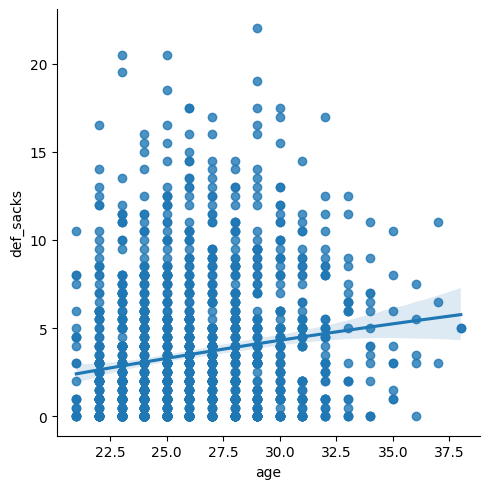

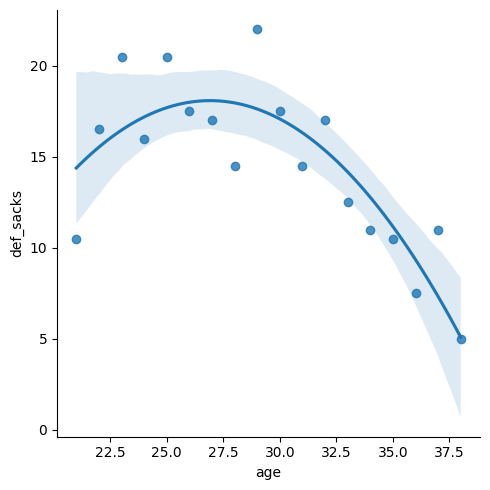

In [40]:
# Trying out different plots
sacks_ax = sns.lmplot(x="age", y="def_sacks", data=de_df, order=2)


max_sacks_df = de_df.groupby("age").max()["def_sacks"].reset_index()
sacks_ax2 = sns.lmplot(x="age", y="def_sacks", data=max_sacks_df, order=2)

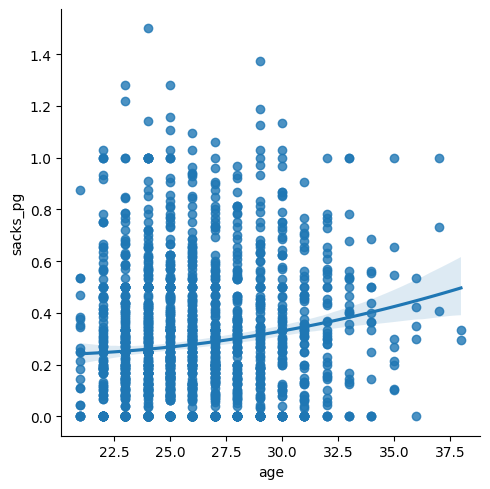

In [41]:
# What if we look at sacks per game?
de_df['sacks_pg'] = de_df['def_sacks'] / de_df['games']
sacks_ax = sns.lmplot(x="age", y="sacks_pg", data=de_df, order=2)

It appears that as players age their number of sacks are going up, but I suspect that only players who perform really well continue to play into their 30s so the sack stat gets inflated. Let's find the players who are still active in their mid 30s and track their stats over time.

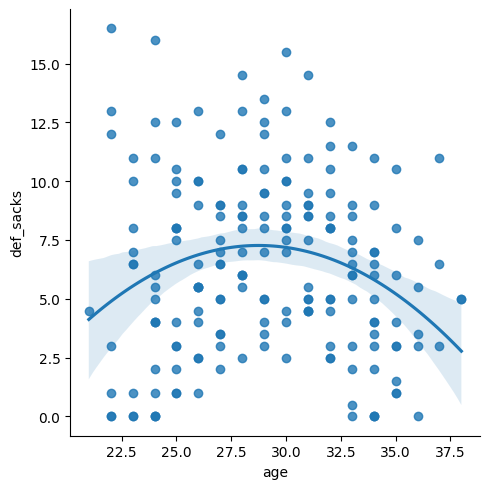

In [42]:
players_gt_age = de_df[de_df['age'] > 33].index.get_level_values(0).unique()
old_players_df = de_df[de_df.index.isin(players_gt_age, level=0)]
sacks_ax = sns.lmplot(x="age", y="def_sacks", data=old_players_df, order=2)

/var/folders/4b/7v01nk757qsbhc05_11mrdnr0000gn/T/ipykernel_79345/2494342975.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['previous_sacks_pg'] = clean_df['previous_sacks'] / de_df['games']
/var/folders/4b/7v01nk757qsbhc05_11mrdnr0000gn/T/ipykernel_79345/2494342975.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['sacks_pg_diff'] = clean_df['sacks_pg'] - clean_df['previous_sacks_pg']


<Axes: xlabel='age', ylabel='sacks_pg'>

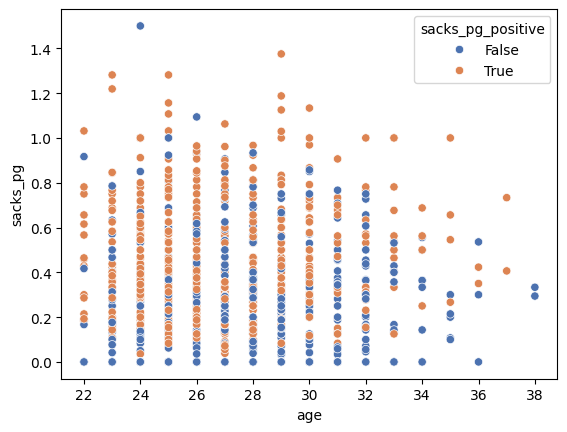

In [60]:
# Visualize change in sacks per game from previous year

# Drop first year for each player
clean_df = de_df[de_df['previous_sacks'] != '']
clean_df['previous_sacks_pg'] = clean_df['previous_sacks'] / de_df['games']
clean_df['sacks_pg_diff'] = clean_df['sacks_pg'] - clean_df['previous_sacks_pg']

sacks_pg_improved = clean_df.eval("sacks_pg_diff > 0").rename("sacks_pg_positive")
sns.scatterplot(x='age', y='sacks_pg', data=clean_df, hue=sacks_pg_improved, hue_norm=(0, 1), palette="deep")